# ***Check GPU***

In [1]:
!nvidia-smi

Mon Sep  2 13:43:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# ***Install Requirements***

In [2]:
!pip install roboflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 1.3 MB/s eta 0:00:00-:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 758.7 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.0/872.0 kB 6.8 MB/s eta 0:00:00a 0:00:01


# **Roboflow Dataset - Beesv2**

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="4LkXLK8ZSbLkfVFlFbMf")
project = rf.workspace("roboflow-100").project("bees-jt5in")
version = project.version(2)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.86, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to bees-2 in yolov8:: 100%|██████████| 16172/16172 [00:04<00:00, 3515.50it/s]


# **LIBRARIES**

In [4]:
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

# **DEPENDENCIES**

In [5]:
HOME = os.getcwd()
HOME

'/kaggle/working'

In [6]:
dataset_dir = f'{HOME}/bees-2/'
models_dir = f'{HOME}/models'
os.makedirs(models_dir, exist_ok=True)

# **Visualize Images of Dataset**

In [7]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [8]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [9]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

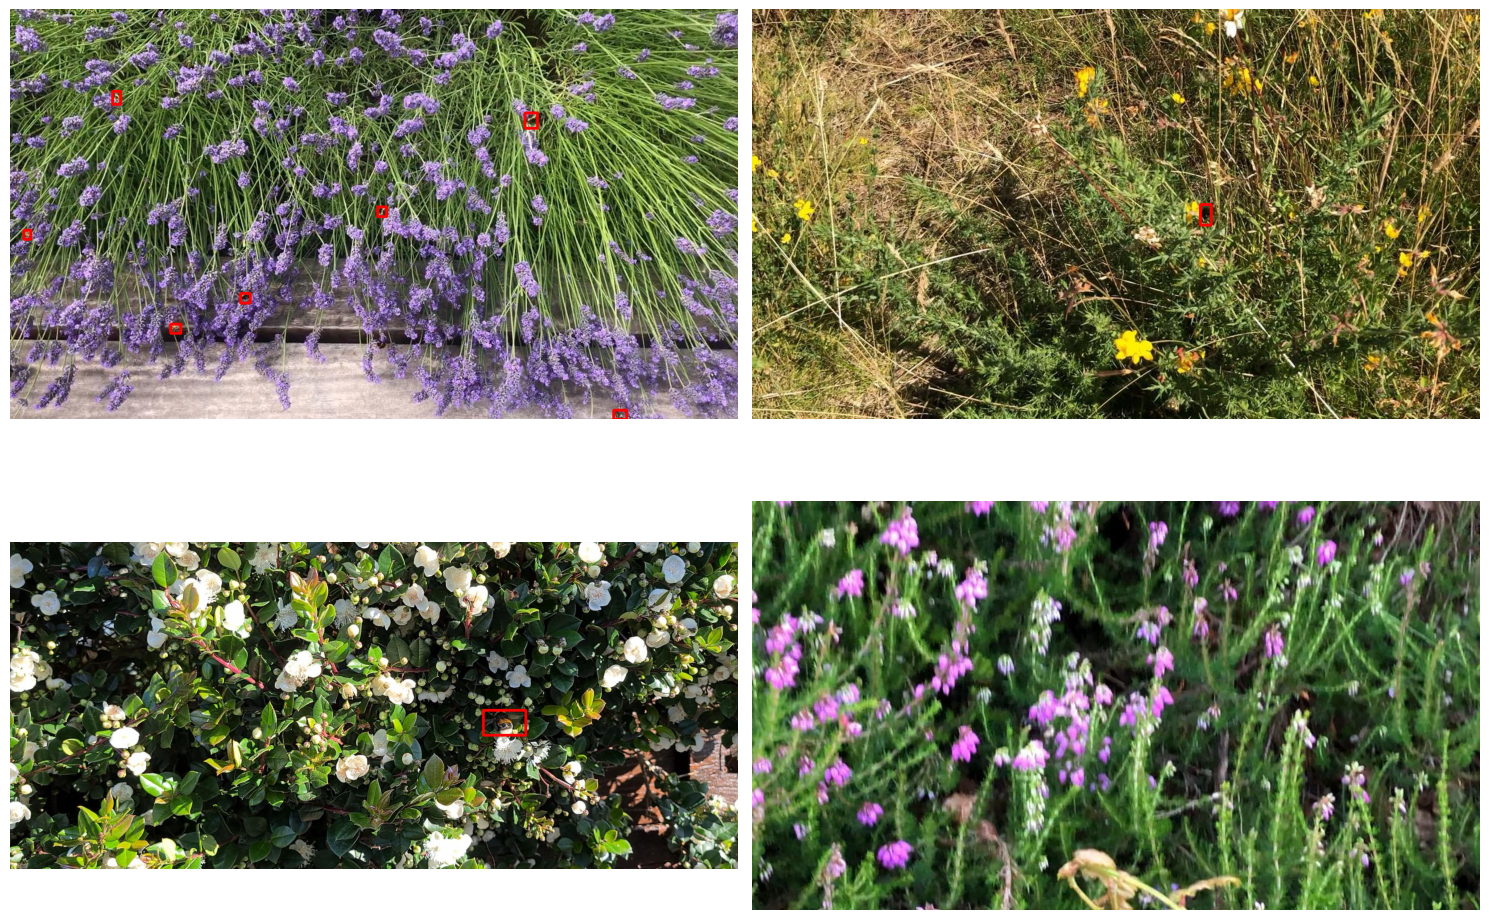

In [10]:
# Visualize a few training images.
plot(
    image_paths=f'{dataset_dir}/train/images/',
    label_paths=f'{dataset_dir}/train/labels/',
    num_samples=4,
)

# **YOLOv8**

In [11]:
import ultralytics
from ultralytics import YOLO

ultralytics.checks()

Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5845.9/8062.4 GB disk)


In [12]:
modelS = YOLO(f"{models_dir}/yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 154MB/s] 


WARNING ⚠️ 'source' is missing. Using 'source=/opt/conda/lib/python3.10/site-packages/ultralytics/assets'.


[ WARN:0@69.429] global loadsave.cpp:241 findDecoder imread_('/kaggle/working/test_image.jpg'): can't open/read file: check file path/integrity



image 1/2 /opt/conda/lib/python3.10/site-packages/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 43.5ms
image 2/2 /opt/conda/lib/python3.10/site-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 1 tie, 43.1ms
Speed: 4.2ms preprocess, 43.3ms inference, 108.5ms postprocess per image at shape (1, 3, 384, 640)


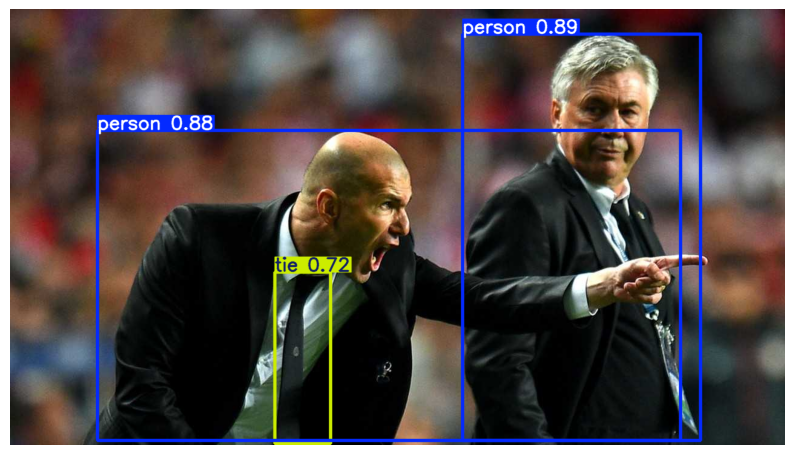

In [13]:
TEST_IMAGE_PATH = f'{HOME}/test_image.jpg'
TEST_IMAGE = cv2.imread(TEST_IMAGE_PATH)
# TEST_IMAGE = cv2.resize(TEST_IMAGE, (640, 640))
CHECK_TEST_RESULT = modelS.predict(source=TEST_IMAGE, conf=0.5, save=False, imgsz=640)

plt.figure(figsize=(10, 10))
for result in CHECK_TEST_RESULT:
    plotted_image = result.plot()
    plotted_image_rgb = cv2.cvtColor(plotted_image, cv2.COLOR_BGR2RGB)
    plt.imshow(plotted_image_rgb)
    plt.axis('off')
plt.show()

## Create YAML file

In [14]:
yamlPath = f'{dataset_dir}/data.yaml'

In [15]:
yamlContent = f"""
path: '{dataset_dir}'
test: 'test/images'
train: 'train/images'
val: 'valid/images'

# class names
nc: 1
names:
  0: 'bees'
"""

with open(f'{yamlPath}', 'w') as yaml:
    yaml.write(yamlContent)

## Define Parameters

In [16]:
EPOCHS = 20
IMAGE_SIZE = 640
BATCH = 32
NAME = 'yolov8s_beesv2'

## Train Model - Medium YOLOv8

In [17]:
# Train Model
modelS.train(
    data=yamlPath,            # Path to the dataset configuration file
    epochs=EPOCHS,            # Number of epochs to train for
    imgsz=IMAGE_SIZE,         # Image size
    batch=BATCH,              # Batch size
    name=NAME                 # Name of the training run
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/models/yolov8s.pt, data=/kaggle/working/bees-2//data.yaml, epochs=20, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_beesv2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

100%|██████████| 755k/755k [00:00<00:00, 14.7MB/s]
2024-09-02 13:44:54,816	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-02 13:44:55,348	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 71.7MB/s]


AMP: checks passed ✅


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
train: Scanning /kaggle/working/bees-2/train/labels... 5640 images, 892 backgrounds, 0 corrupt: 100%|██████████| 5640/5640 [00:04<00:00, 1395.75it/s]


train: New cache created: /kaggle/working/bees-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/bees-2/valid/labels... 1604 images, 237 backgrounds, 0 corrupt: 100%|██████████| 1604/1604 [00:01<00:00, 1445.20it/s]


val: New cache created: /kaggle/working/bees-2/valid/labels.cache
Plotting labels to runs/detect/yolov8s_beesv2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8s_beesv2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.33G      2.414       3.83      1.527          8        640: 100%|██████████| 177/177 [01:27<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]


                   all       1604       1950      0.522      0.491      0.461      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.31G      2.042      1.684      1.209         23        640: 100%|██████████| 177/177 [01:26<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.76it/s]

                   all       1604       1950      0.702      0.598       0.66      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       7.3G      1.988      1.439      1.186          8        640: 100%|██████████| 177/177 [01:25<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]

                   all       1604       1950       0.69      0.641      0.669       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      7.33G      1.969      1.373      1.173         12        640: 100%|██████████| 177/177 [01:25<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]

                   all       1604       1950      0.736      0.698       0.73      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       7.3G      1.925      1.273      1.152         27        640: 100%|██████████| 177/177 [01:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.70it/s]

                   all       1604       1950       0.74      0.701      0.732      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      7.33G      1.881      1.202      1.137         19        640: 100%|██████████| 177/177 [01:25<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.75it/s]

                   all       1604       1950      0.728      0.689      0.737      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      7.34G      1.866      1.173      1.132         16        640: 100%|██████████| 177/177 [01:25<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all       1604       1950      0.784      0.747      0.801       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      7.33G      1.835      1.131      1.111         16        640: 100%|██████████| 177/177 [01:25<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.71it/s]

                   all       1604       1950      0.815      0.731      0.814      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      7.29G      1.814      1.112      1.112         20        640: 100%|██████████| 177/177 [01:25<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all       1604       1950       0.79      0.769      0.803      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      7.65G      1.777       1.07      1.094         10        640: 100%|██████████| 177/177 [01:25<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.73it/s]

                   all       1604       1950      0.812      0.777      0.828      0.388


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.29G      1.776      1.049      1.124         11        640: 100%|██████████| 177/177 [01:25<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.82it/s]

                   all       1604       1950      0.813      0.782      0.824      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      7.65G      1.744      1.013      1.108          8        640: 100%|██████████| 177/177 [01:24<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.83it/s]

                   all       1604       1950      0.832      0.772      0.835      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.29G      1.727     0.9728      1.108          7        640: 100%|██████████| 177/177 [01:24<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all       1604       1950       0.83       0.77      0.845      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.33G      1.707     0.9414      1.099          6        640: 100%|██████████| 177/177 [01:24<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.86it/s]

                   all       1604       1950      0.815      0.762      0.836      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.29G      1.676     0.9272      1.084          8        640: 100%|██████████| 177/177 [01:24<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.83it/s]

                   all       1604       1950      0.835       0.76      0.837      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.32G      1.666     0.9031      1.087          7        640: 100%|██████████| 177/177 [01:24<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:08<00:00,  2.89it/s]

                   all       1604       1950       0.84      0.807       0.86      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.29G      1.642      0.865      1.072         12        640: 100%|██████████| 177/177 [01:24<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.84it/s]

                   all       1604       1950      0.843      0.815      0.867      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.37G       1.62     0.8473      1.063          7        640: 100%|██████████| 177/177 [01:24<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.76it/s]

                   all       1604       1950       0.83      0.823      0.863      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.29G      1.597     0.8289      1.049         12        640: 100%|██████████| 177/177 [01:24<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.88it/s]

                   all       1604       1950      0.845      0.825      0.873      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      7.32G      1.573     0.8006      1.045          7        640: 100%|██████████| 177/177 [01:24<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.88it/s]

                   all       1604       1950      0.845      0.828      0.879       0.44



20 epochs completed in 0.535 hours.
Optimizer stripped from runs/detect/yolov8s_beesv2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_beesv2/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_beesv2/weights/best.pt...
Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.36it/s]


                   all       1604       1950      0.846      0.828      0.879       0.44
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/yolov8s_beesv2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e5b2fb5d330>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## Evaluate Model

In [18]:
evaluateBEES_Sval = modelS.val(
    data = yamlPath,
    split = 'val',
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/working/bees-2/valid/labels.cache... 1604 images, 237 backgrounds, 0 corrupt: 100%|██████████| 1604/1604 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:15<00:00,  3.30it/s]


                   all       1604       1950      0.846      0.829       0.88       0.44
Speed: 0.1ms preprocess, 5.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/yolov8s_beesv22


In [19]:
evaluateBEES_Stest = modelS.val(
    data = yamlPath,
    split = 'test',
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /kaggle/working/bees-2/test/labels... 836 images, 127 backgrounds, 0 corrupt: 100%|██████████| 836/836 [00:00<00:00, 1325.31it/s]

val: New cache created: /kaggle/working/bees-2/test/labels.cache



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.00it/s]


                   all        836        973      0.856      0.864      0.893      0.441
Speed: 0.1ms preprocess, 5.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/yolov8s_beesv23


# **DOWNLOAD TRAINED MODEL**

In [20]:
import shutil
shutil.make_archive('runs', 'zip', 'runs')

from IPython.display import FileLink
FileLink(r'runs.zip')

/kaggle/working/runs.zip

# **PLOTS**

In [21]:
from IPython.display import display, Image
from IPython import display
display.clear_output()

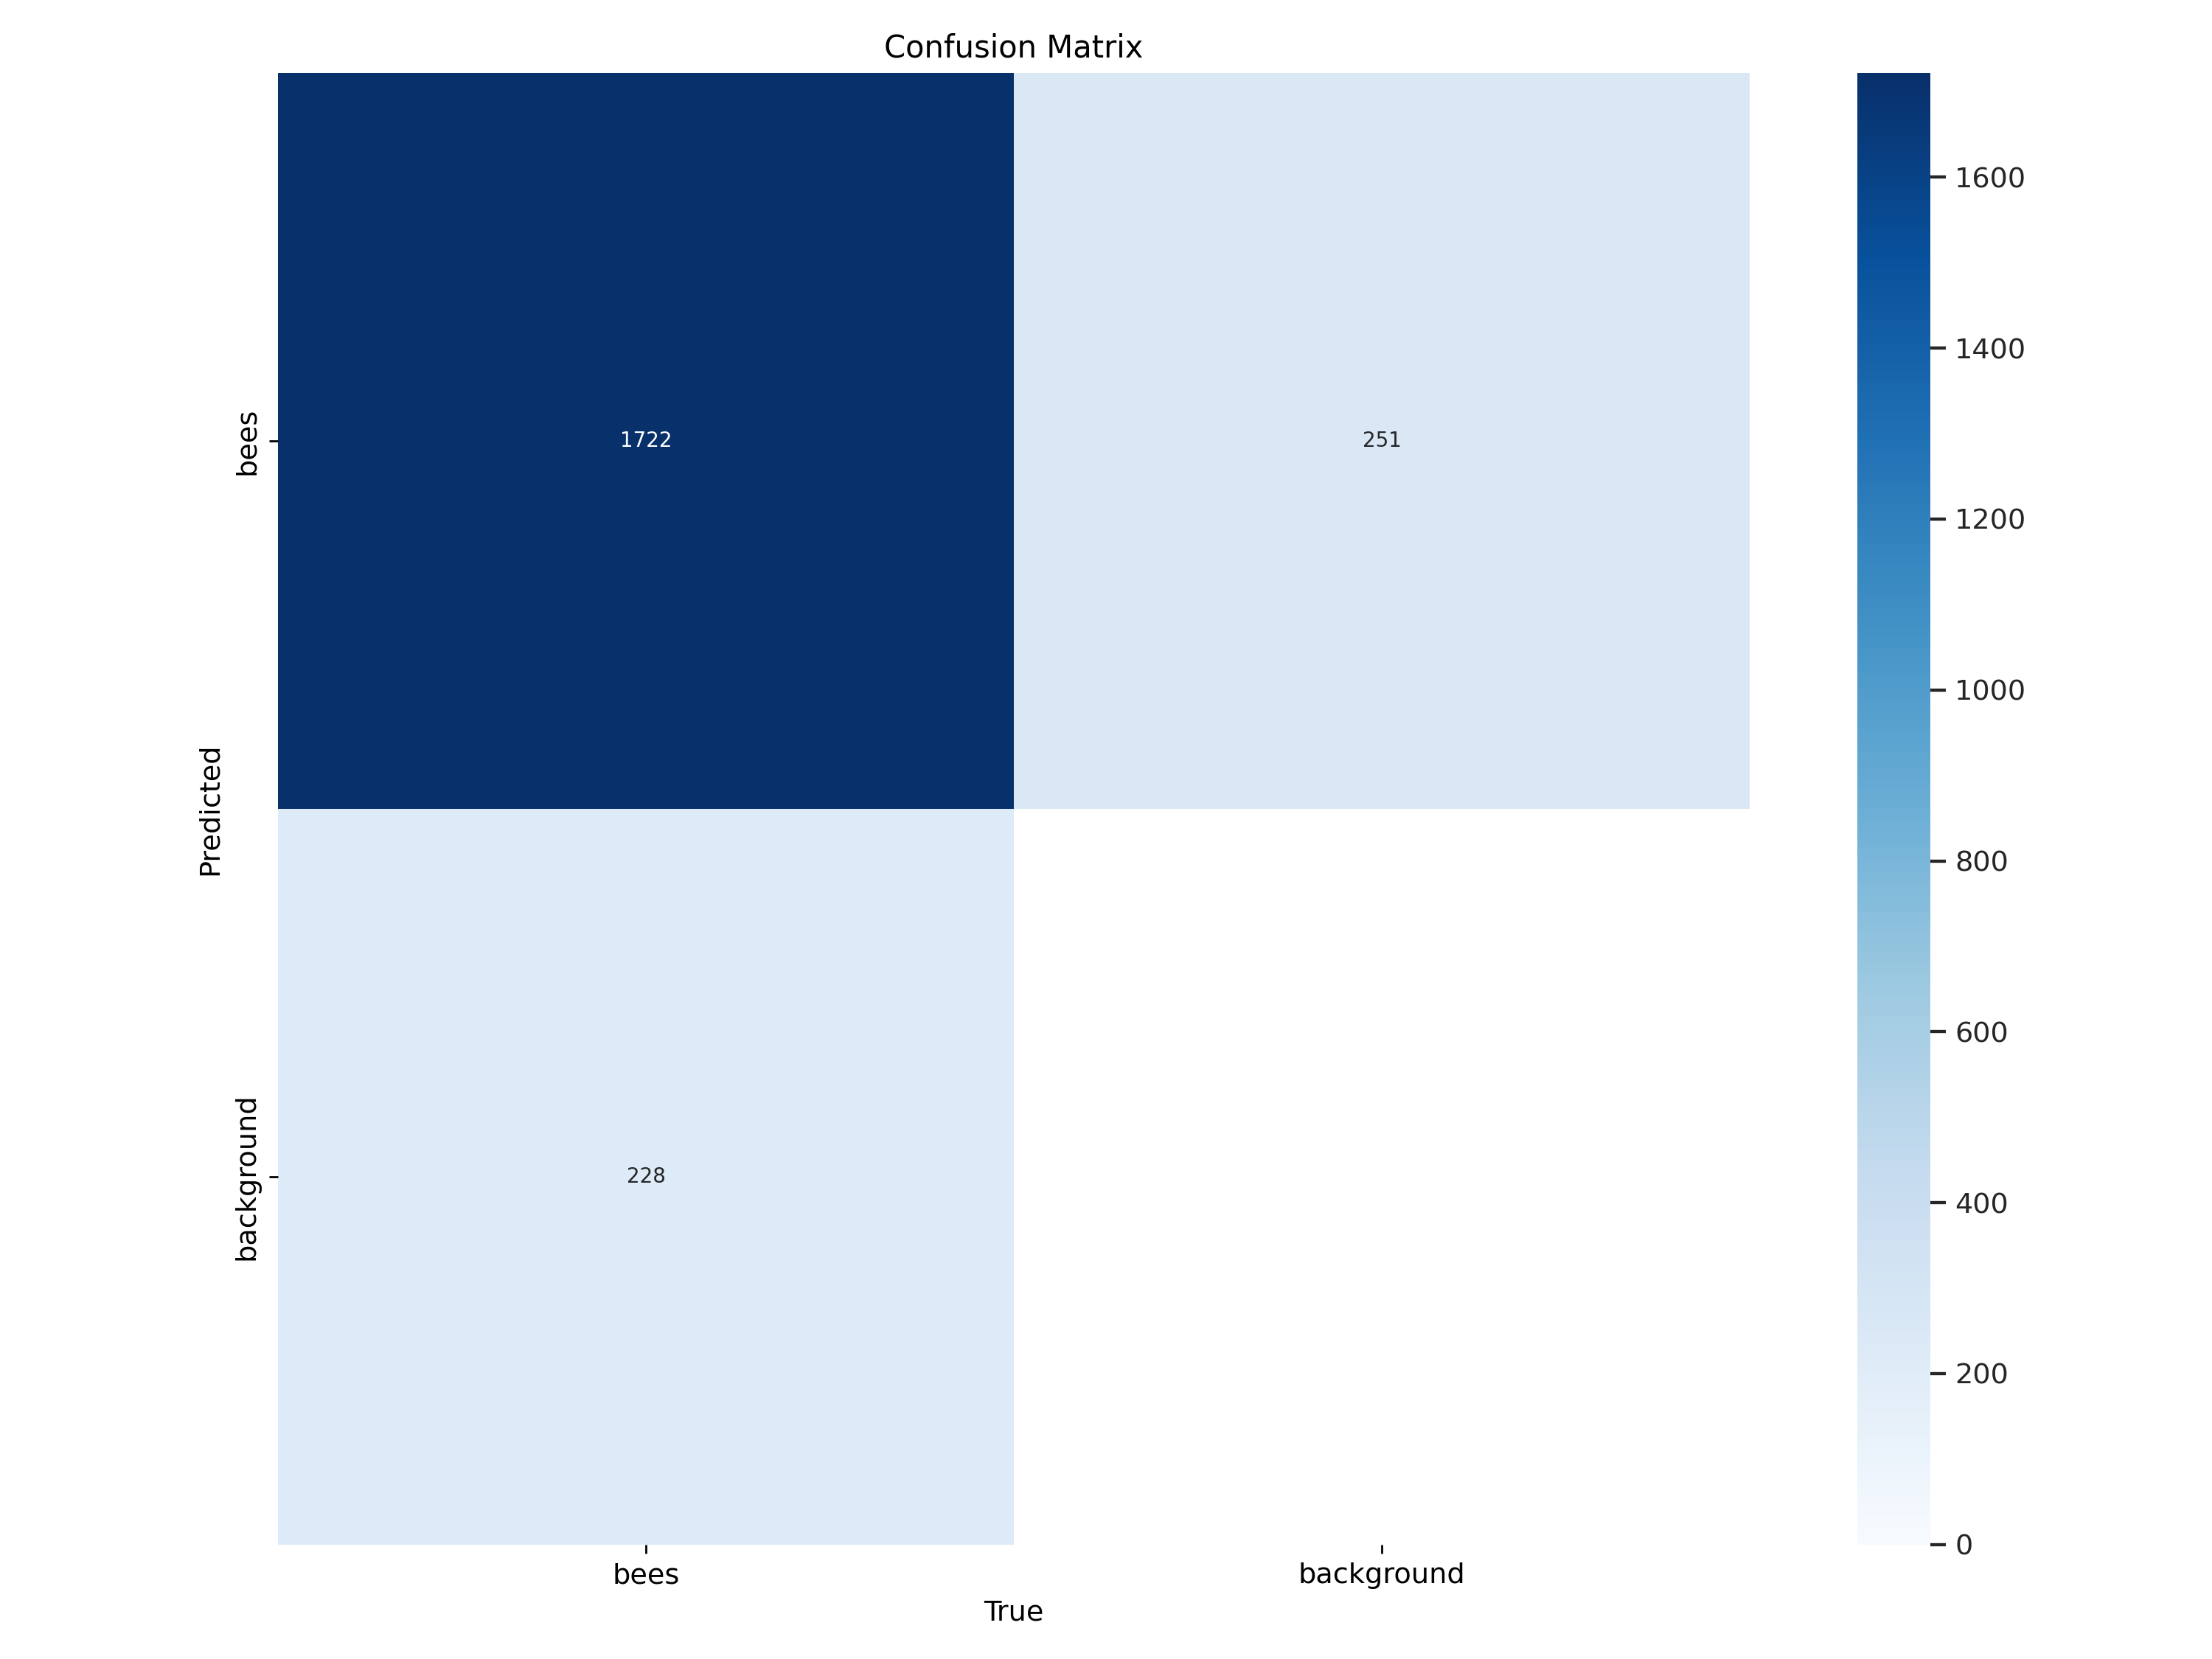

In [22]:
Image(filename=f'{HOME}/runs/detect/{NAME}/confusion_matrix.png', width=600)

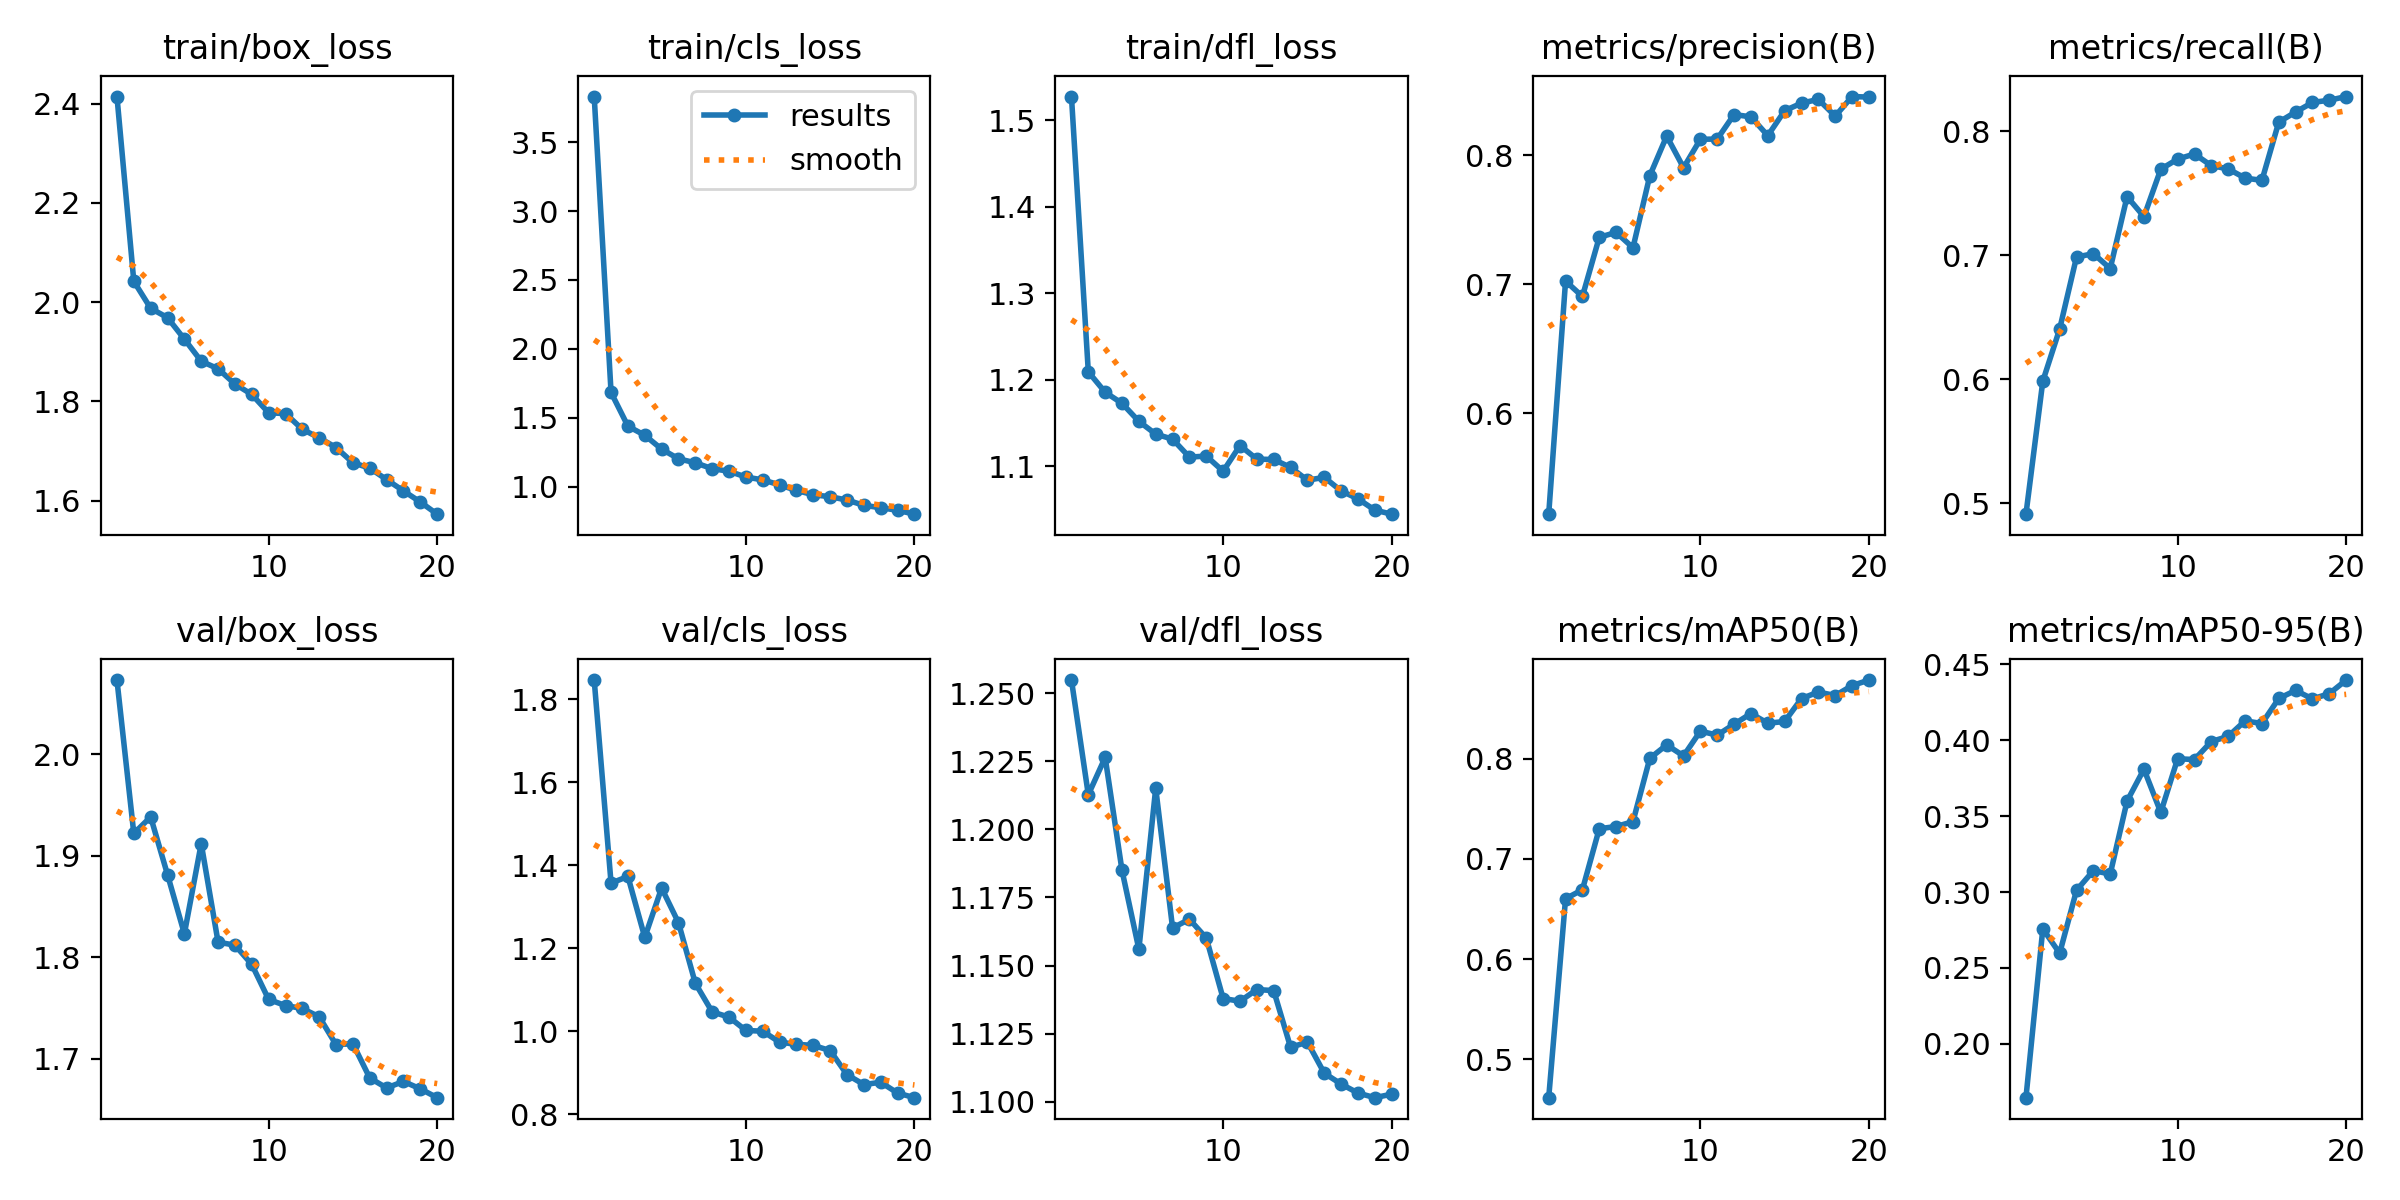

In [23]:
Image(filename=f'{HOME}/runs/detect/{NAME}/results.png', width=600)

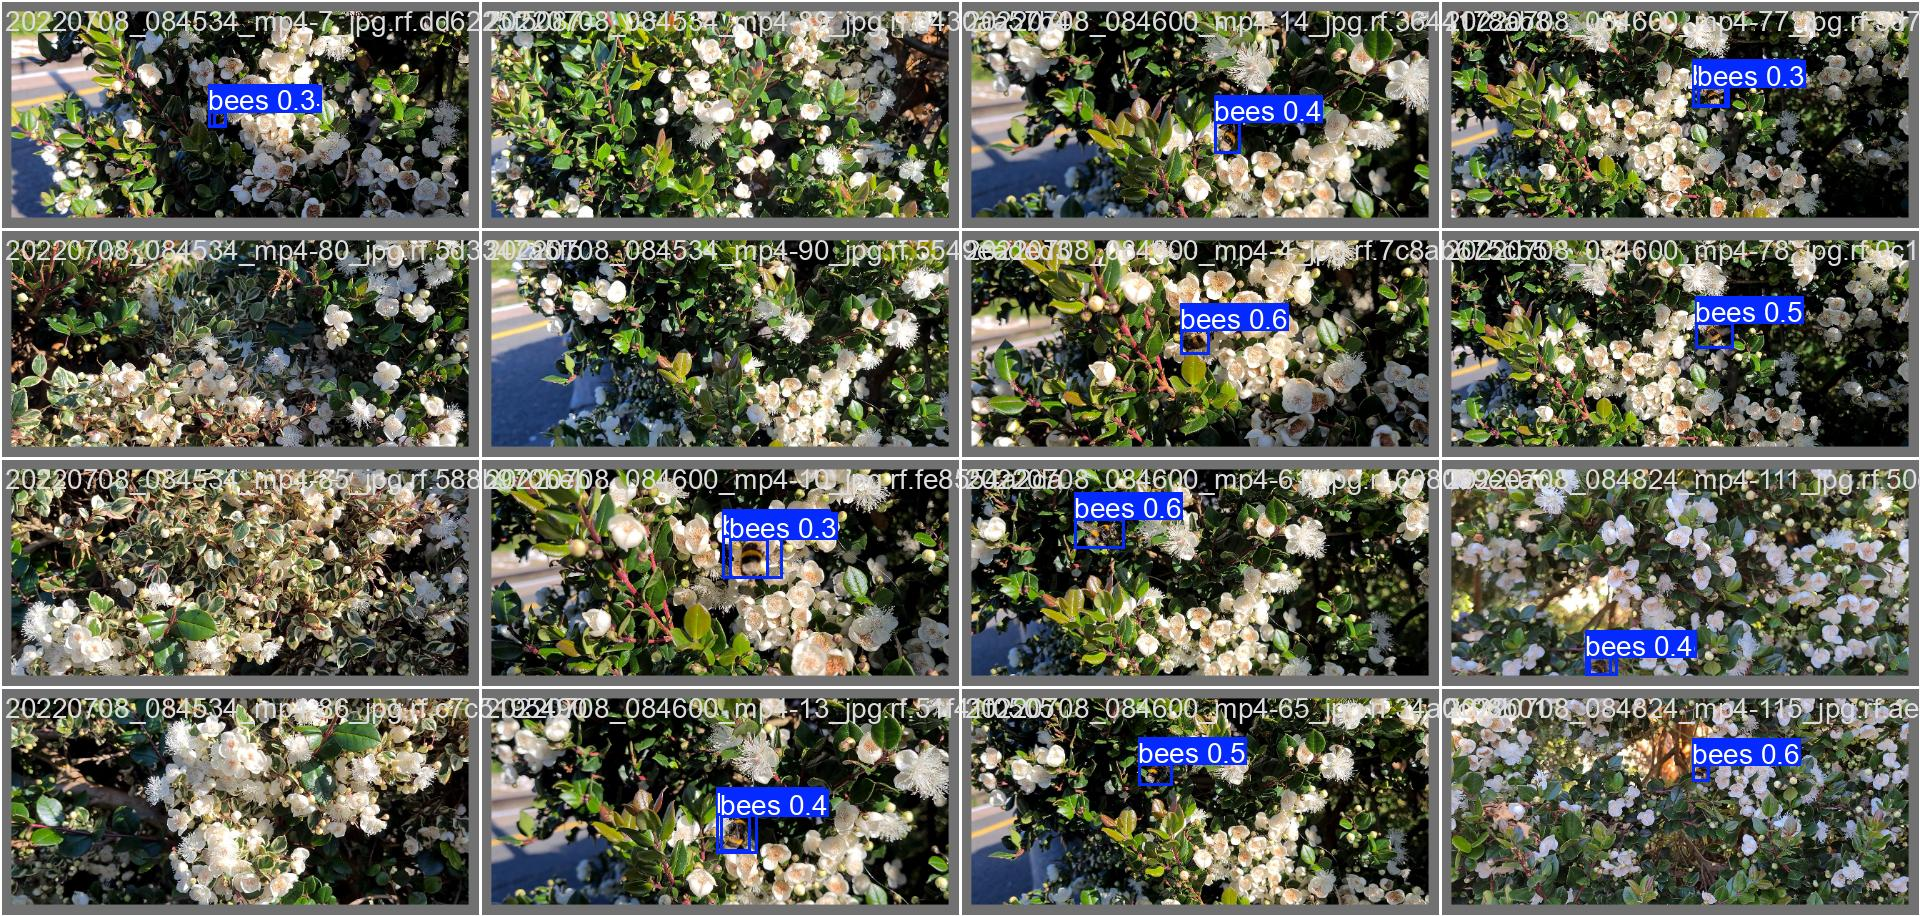

In [24]:
Image(filename=f'{HOME}/runs/detect/{NAME}/val_batch0_pred.jpg', width=600)

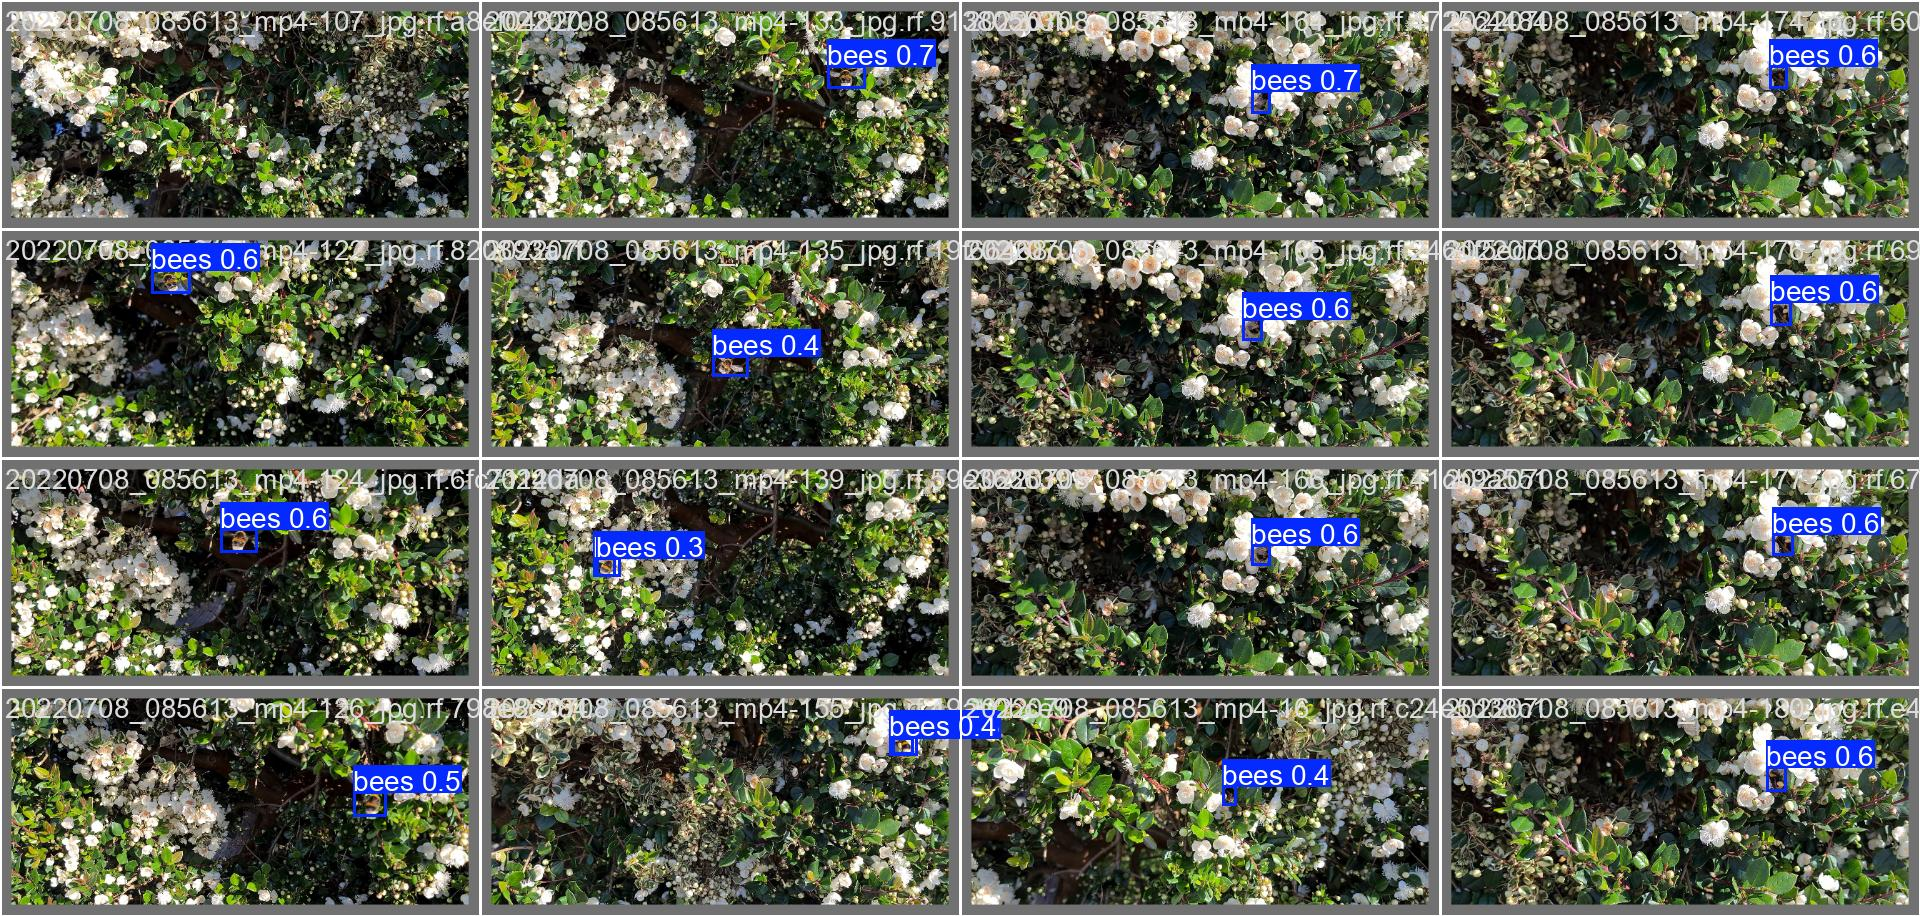

In [25]:
Image(filename=f'{HOME}/runs/detect/{NAME}/val_batch1_pred.jpg', width=600)